# DSCI 100 – Data Science Project: Planning Stage

## Predicting which players contribute large amounts of data

This notebook is my individual planning report for the DSCI 100 project. I use the provided `players.csv` and `sessions.csv` files from the Minecraft research server to explore the data, describe the variables, state my question, and outline a plan for modelling.

I focus on **Question 2** from the project description:

> We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.


In [5]:
# Load required packages
library(tidyverse)
library(ggplot2)
library(lubridate)

# Make printing cleaner
options(dplyr.width = Inf)

## Data Description

### File 1 – `players.csv`

This file contains one row per unique player, with information about their demographics and how much they have played on the server.

- **Number of observations:** 196 players  
- **Number of variables:** 9  
- Note: 2 of the 9 variables are completely empty (all values are `NA`).

In [6]:
# Variable description table for players.csv
dataset <- matrix(c(
  "experience",       "Character",        "Experience level of players",
  "subscribe",        "Boolean/Logical",  "Whether player is subscribed",
  "hashedEmail",      "Character",        "Encrypted email id of players",
  "played_hours",     "Double/Numeric",   "Number of hours played",
  "name",             "Character",        "Name of player",
  "gender",           "Character",        "Gender of player",
  "age",              "Integer",          "Age of player",
  "individualId",     "Logical",          "Unique player identification (empty)",
  "organizationName", "Logical",          "Name of player's organization (empty)"
), ncol = 3, byrow = TRUE)

colnames(dataset) <- c("Variable Name", "Type of Variable", "Description of Data inside Variable")
rownames(dataset) <- 1:9

table_players <- as.table(dataset)
table_players

  Variable Name    Type of Variable Description of Data inside Variable  
1 experience       Character        Experience level of players          
2 subscribe        Boolean/Logical  Whether player is subscribed         
3 hashedEmail      Character        Encrypted email id of players        
4 played_hours     Double/Numeric   Number of hours played               
5 name             Character        Name of player                       
6 gender           Character        Gender of player                     
7 age              Integer          Age of player                        
8 individualId     Logical          Unique player identification (empty) 
9 organizationName Logical          Name of player's organization (empty)

### File 2 – `sessions.csv`

This file contains one row per individual play session for players on the server.

- **Number of observations:** 1535 sessions  
- **Number of variables:** 5  

In [7]:
# Variable description table for sessions.csv
dataset2 <- matrix(c(
  "hashedEmail",         "Character",      "Encrypted email id of players",
  "start_time",          "Character",      "Start time of playing session",
  "end_time",            "Character",      "End time of playing session",
  "original_start_time", "Double/Numeric", "Start time in scientific notation",
  "original_end_time",   "Double/Numeric", "End time in scientific notation"
), ncol = 3, byrow = TRUE)

colnames(dataset2) <- c("Variable Name", "Type of Variable", "Description of Data inside Variable")
rownames(dataset2) <- 1:5

table_sessions <- as.table(dataset2)
table_sessions

  Variable Name       Type of Variable Description of Data inside Variable
1 hashedEmail         Character        Encrypted email id of players      
2 start_time          Character        Start time of playing session      
3 end_time            Character        End time of playing session        
4 original_start_time Double/Numeric   Start time in scientific notation  
5 original_end_time   Double/Numeric   End time in scientific notation    

## Issues and Potential Problems

### Direct issues visible in the data

- **Empty columns in `players.csv`:**  
  The variables `individualId` and `organizationName` are completely `NA`. Based on their names, they likely originally contained identifiers or organization details that were removed to protect player privacy.

- **Missing values in `sessions.csv`:**  
  Some rows are missing `end_time` even though other variables are filled in. This might happen if players did not properly log out. These missing end times can create noise or bias when computing session durations.

### Less obvious / contextual issues

- **Method of data collection not described:**  
  For `sessions.csv`, we are not told exactly how session times were measured. There could be a gap between actual gameplay time and the time someone is logged into the server, which means session duration may not perfectly reflect active play.

## Question

The group chose the project question about "kinds" of players who contribute a large amount of data. In the original project handout this is **Question 2**:

> We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

### Response variable of interest

- **`played_hours`** (from `players.csv`): numeric, total hours played for each player.  
  This is my measure of how much data a player contributes.

### Explanatory variables (main focus)

From `players.csv`:

- **`experience`** (`chr`): main variable to define “kinds” of players (e.g., Beginner, Amateur, Regular, Veteran, Pro).  
- **`age`** (`int`): age of the player.  
- **`gender`** (`chr`): gender identity.  
- **`subscribe`** (`lgl`): whether the player is subscribed.

From `sessions.csv` (after wrangling):

- Aggregated features such as:
  - number of sessions per player  
  - average session duration  
  - total session time  
  - typical times/days of activity

These session-level features, combined with `players.csv`, will help refine what kinds of players generate lots of data.


## Exploratory Data Analysis and Wrangling

In this section I load the data, check basic summaries (dimensions, types, missing values), clean up the date/time columns for sessions, and merge the player and session data using `hashedEmail`. Then I create a few simple visualizations to explore how `played_hours` relates to experience level, age, and session behaviour.

In [8]:
# Read in the two datasets directly from the provided URLs
players_data <- read_csv(
  "https://raw.github.students.cs.ubc.ca/vdixit20/DSCI-100-Planning-Stage-Individual-/refs/heads/main/players.csv?token=GHSAT0AAAAAAAAAIXAT2NPXQ3JDPTAO56F22JAWH4A"
)

sessions_data <- read_csv(
  "https://raw.github.students.cs.ubc.ca/vdixit20/DSCI-100-Planning-Stage-Individual-/refs/heads/main/sessions.csv?token=GHSAT0AAAAAAAAAIXATC5WQ5DNTKELIEH5A2JAWFRQ"
)

players_data
sessions_data


ERROR: Error in open.connection(structure(5L, class = c("curl", "connection"), conn_id = <pointer: 0x1e9>), : HTTP error 404.


In [4]:
# Summary for players_data
players_data_summary <- list(
  "Number of Observations"                  = nrow(players_data),
  "Number of Variables"                     = ncol(players_data),
  "Variable Name and Datatype"              = sapply(players_data, class),
  "Number of Missing Values in each column" = colSums(is.na(players_data))
)

players_data_summary

ERROR: Error in eval(expr, envir, enclos): object 'players_data' not found


In [202]:
# Summary for sessions_data
sessions_data_summary <- list(
  "Number of Observations"                  = nrow(sessions_data),
  "Number of Variables"                     = ncol(sessions_data),
  "Variable Name and Datatype"              = sapply(sessions_data, class),
  "Number of Missing Values in each column" = colSums(is.na(sessions_data))
)

sessions_data_summary

$`Number of Observations`
[1] 1535

$`Number of Variables`
[1] 5

$`Variable Name and Datatype`
        hashedEmail          start_time            end_time original_start_time 
        "character"         "character"         "character"           "numeric" 
  original_end_time 
          "numeric" 

$`Number of Missing Values in each column`
        hashedEmail          start_time            end_time original_start_time 
                  0                   0                   2                   0 
  original_end_time 
                  2

In [203]:
# Convert start_time and end_time to proper date-time format
# The timestamps are in "dd/mm/yyyy hh:mm" format, so use dmy_hms()
sessions_simplified <- sessions_data |>
  mutate(
    start_time = dmy_hms(start_time),
    end_time   = dmy_hms(end_time)
  )

sessions_simplified

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2020-07-01 00:18:12,2020-07-01 00:18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2020-06-18 00:23:33,2020-06-18 00:23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2020-07-26 00:17:34,2020-07-26 00:17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2020-07-26 00:03:22,2020-07-26 00:03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2020-05-26 00:16:01,2020-05-26 00:16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2020-06-24 00:15:08,2020-06-24 00:17:10,1.71916e+12,1.71916e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2020-04-16 00:07:12,2020-04-16 00:07:21,1.71317e+12,1.71317e+12
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,2020-09-22 00:02:13,2020-09-22 00:02:30,1.72688e+12,1.72689e+12
96e190b0bf3923cd8d349eee467c09d1130af143335779251492eb4c2c058a5f,2020-06-22 00:02:31,2020-06-22 00:02:49,1.71894e+12,1.71894e+12


In [204]:
# Merge player and session data on hashedEmail and drop rows with missing end_time
data_merged <- merge(players_data, sessions_simplified, by = "hashedEmail") |>
  filter(!is.na(end_time)) |>
  arrange(name)

data_merged

hashedEmail,experience,subscribe,played_hours,name,gender,Age,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dttm>,<dbl>,<dbl>
aea049eaa7cb10db386a62990220d205ceb2a4c473cae3ec7bab107278c26559,Beginner,TRUE,0.2,Aarav,Prefer not to say,17,2020-06-15 00:20:35,2020-06-15 00:20:53,1.71840e+12,1.71840e+12
22a78bfd44e46931261d06864b92cf9a8fd77fb02bec66cb71646dd9da222a0d,Amateur,TRUE,1.2,Aaron,Non-binary,17,2020-08-03 00:23:37,2020-08-04 00:00:35,1.72264e+12,1.72265e+12
22a78bfd44e46931261d06864b92cf9a8fd77fb02bec66cb71646dd9da222a0d,Amateur,TRUE,1.2,Aaron,Non-binary,17,2020-05-21 00:19:01,2020-05-21 00:19:29,1.71623e+12,1.71623e+12
d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,Pro,TRUE,0.2,Ahmed,Other,NA,2020-05-09 00:19:29,2020-05-09 00:19:44,1.71520e+12,1.71520e+12
88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62,Veteran,FALSE,1.4,Aiden,Prefer not to say,25,2020-08-11 00:06:23,2020-08-11 00:07:06,1.72327e+12,1.72327e+12
88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62,Veteran,FALSE,1.4,Aiden,Prefer not to say,25,2020-04-19 00:23:22,2020-04-19 00:23:31,1.71348e+12,1.71348e+12
88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62,Veteran,FALSE,1.4,Aiden,Prefer not to say,25,2020-04-21 00:00:09,2020-04-21 00:00:28,1.71357e+12,1.71357e+12
88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62,Veteran,FALSE,1.4,Aiden,Prefer not to say,25,2020-05-02 00:00:58,2020-05-02 00:01:24,1.71453e+12,1.71453e+12
88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62,Veteran,FALSE,1.4,Aiden,Prefer not to say,25,2020-08-02 00:23:12,2020-08-02 00:23:23,1.72255e+12,1.72255e+12


## Visualizations of the Original Data

I now create three basic plots:

1. A scatterplot of **experience level vs played hours**.  
2. A scatterplot of **age vs played hours**.  
3. A histogram of **session durations** (based on start and end times).

These are not final models, but they give an initial sense of which groups of players appear to contribute more hours and how session behaviour varies.


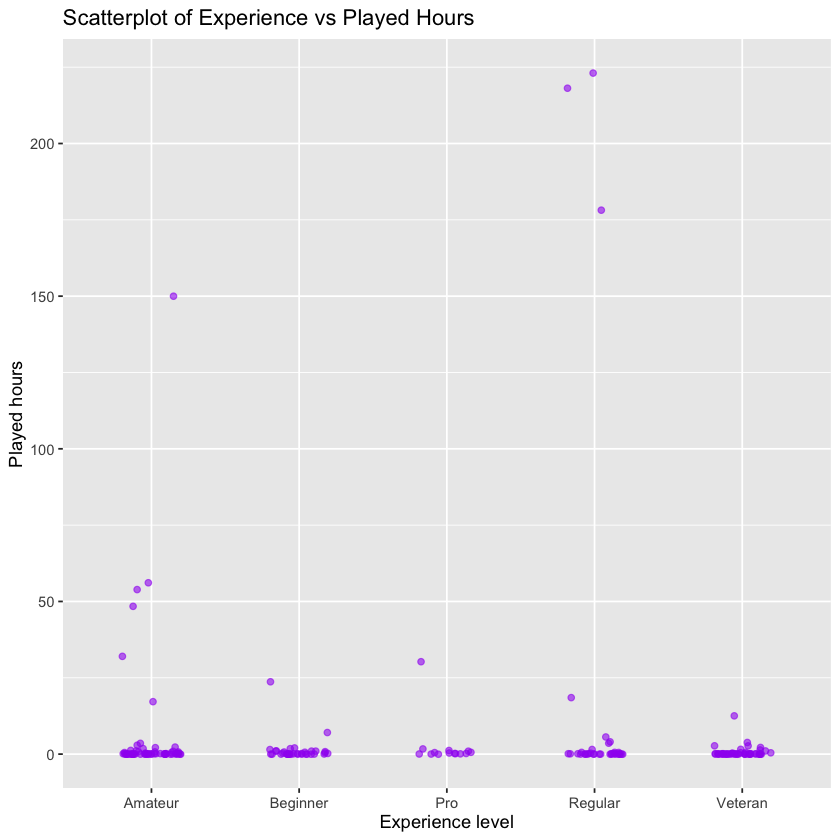

In [194]:
# Scatterplot: Experience vs Played Hours
players_plot_1 <- players_data |>
  ggplot(aes(x = experience, y = played_hours)) +
  geom_jitter(width = 0.2, color = "purple", alpha = 0.6) +
  labs(
    title = "Scatterplot of Experience vs Played Hours",
    x = "Experience level",
    y = "Played hours"
  )

players_plot_1

Warning message:
“Removed 2 rows containing
missing values or values
outside the scale range
(`geom_point()`).”


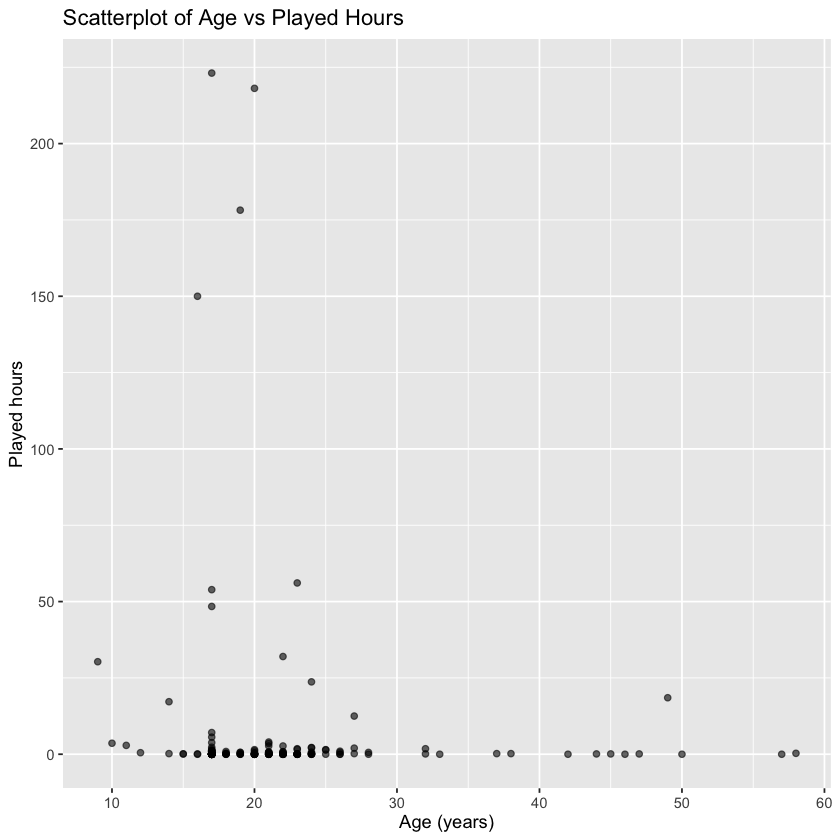

In [195]:
# --- Scatterplot: Age vs Played Hours (final) ---

# If the column is called "Age", rename it once to "age"
if ("Age" %in% names(players_data)) {
  players_data <- players_data |>
    dplyr::rename(age = Age)
}

players_plot_2 <- players_data |>
  ggplot(aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Scatterplot of Age vs Played Hours",
    x = "Age (years)",
    y = "Played hours"
  )

players_plot_2

Warning message:
“Removed 2 rows containing
non-finite outside the
scale range
(`stat_bin()`).”


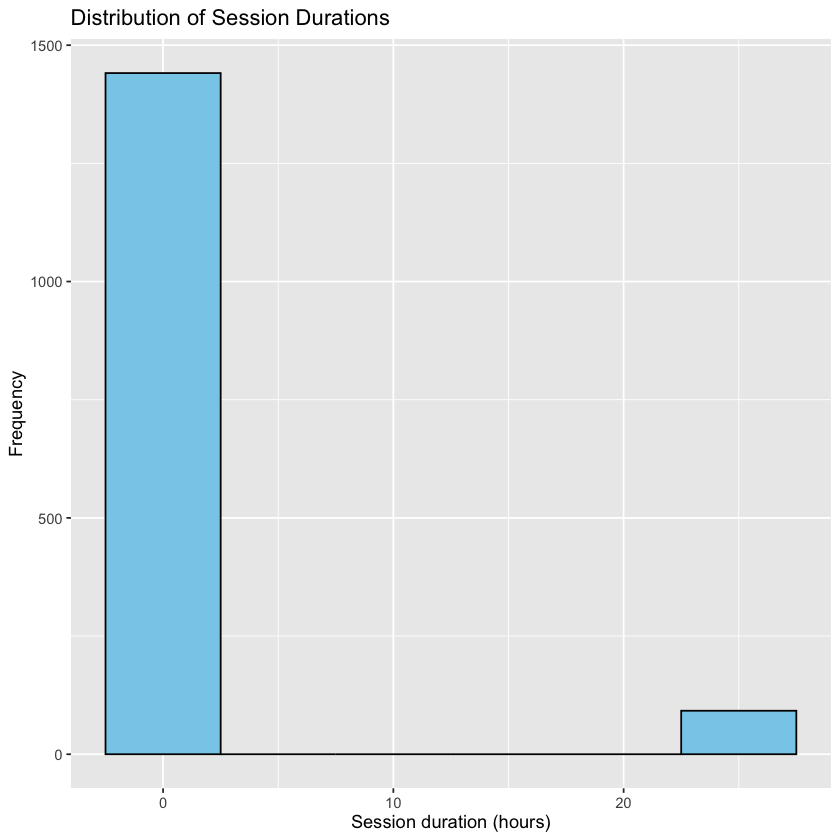

In [196]:
# Histogram of session durations (in hours)
sessions_plot <- sessions_simplified |>
  ggplot(aes(x = as.numeric(difftime(end_time, start_time, units = "hours")))) +
  geom_histogram(binwidth = 5, fill = "skyblue", color = "black") +
  labs(
    title = "Distribution of Session Durations",
    x = "Session duration (hours)",
    y = "Frequency"
  )

sessions_plot

## Methods and Modelling Plan

### Proposed approach

Because the response variable `played_hours` is numeric but the project question is phrased in terms of "kinds" of players, I plan to:

- Treat `played_hours` as a measure of how much data a player contributes.
- Use **classification and/or clustering** to group players into types based on their characteristics and play patterns.

Some possible approaches:

- **Classification:**  
  Create categories such as "high data contributor" vs "low data contributor" based on thresholds of `played_hours`, and then build a classifier using predictors like `experience`, `age`, `gender`, `subscribe`, and aggregated session features (total session duration, number of sessions, average session length).

- **Clustering:**  
  Cluster players using the same variables to see if natural groups emerge (e.g., highly active veterans, casual beginners, etc.). This can help interpret what “kinds” of players correspond to heavy data usage.

### Data processing and model comparison

- Split the data into **training (80%)** and **test (20%)** sets.
- On the training set, use **cross-validation** (e.g., 5-fold) to compare models and tune hyperparameters.
- Evaluate model performance on the held-out test set (e.g., accuracy for classification, or appropriate clustering validation measures).
- Compare how much each variable contributes to identifying players who generate large amounts of data.
- Use the final model(s) and exploratory plots to answer Question 2: which combinations of experience level, demographics, and session behaviour describe the players who contribute the most data.

# GitHub Repository

A link to the project repository will be included here, with a minimum of five meaningful commits documenting data loading, wrangling, visualizations, and report development. 

https://github.students.cs.ubc.ca/vdixit20/DSCI-100-Planning-Stage-Individual-.git
